In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Importing dependencies
%load_ext cudf.pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn

In [ ]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 25.8 MB/s eta 0:00:00


# Final Approach

In [ ]:
df_2021 = pd.read_csv('/content/drive/MyDrive/IOMT/wustl_iiot_2021.csv')
df_2020 = pd.read_csv('/content/drive/MyDrive/IOMT/wustl-ehms-2020.csv')
df_2024 = pd.read_csv('/content/drive/MyDrive/IOMT/wustl_hdrl_2024.csv')

In [ ]:
df_2021 = df_2021.rename(columns={'Target': 'Label'})


In [ ]:
d = [df_2021.keys() , df_2020.keys() , df_2024.keys()]
for keys in d:
  print(keys)

Index(['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'Mean', 'Sport', 'Dport',
       'SrcPkts', 'DstPkts', 'TotPkts', 'DstBytes', 'SrcBytes', 'TotBytes',
       'SrcLoad', 'DstLoad', 'Load', 'SrcRate', 'DstRate', 'Rate', 'SrcLoss',
       'DstLoss', 'Loss', 'pLoss', 'SrcJitter', 'DstJitter', 'SIntPkt',
       'DIntPkt', 'Proto', 'Dur', 'TcpRtt', 'IdleTime', 'Sum', 'Min', 'Max',
       'sDSb', 'sTtl', 'dTtl', 'sIpId', 'dIpId', 'SAppBytes', 'DAppBytes',
       'TotAppByte', 'SynAck', 'RunTime', 'sTos', 'SrcJitAct', 'DstJitAct',
       'Traffic', 'Label'],
      dtype='object')
Index(['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'Sport', 'Dport', 'SrcBytes',
       'DstBytes', 'SrcLoad', 'DstLoad', 'SrcGap', 'DstGap', 'SIntPkt',
       'DIntPkt', 'SIntPktAct', 'DIntPktAct', 'SrcJitter', 'DstJitter',
       'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'dMinPktSz', 'Dur', 'Trans',
       'TotPkts', 'TotBytes', 'Load', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss',
       'Rate', 'SrcMac', 'DstMac', 'Packet_n

## Working on the 2020 dataset

In [ ]:
df_2020.head()

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,Packet_num,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,->,e,10.0.1.172,10.0.1.150,58059,1111,496.0,186.0,276914.0,92305.0,...,1,28.9,0,0,0,0,0,0,0.0,0
1,->,e,10.0.1.172,10.0.1.150,58062,1111,496.0,186.0,230984.0,76995.0,...,2,28.9,0,0,0,0,78,17,0.4,0
2,->,e,10.0.1.172,10.0.1.150,58065,1111,496.0,186.0,218470.0,72823.0,...,3,28.9,89,104,0,0,78,17,0.4,0
3,->,e,10.0.1.172,10.0.1.150,58067,1111,496.0,186.0,203376.0,67792.0,...,4,28.9,89,104,0,0,79,17,0.4,0
4,->,e,10.0.1.172,10.0.1.150,58069,1111,496.0,186.0,235723.0,78574.0,...,5,28.9,89,101,0,0,79,17,0.4,0


In [ ]:
df_2020 = df_2020.drop('Dir' , axis = 1)

In [ ]:
df_2020.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 16318 entries, 0 to 16317
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Flgs        16318 non-null  object
 1   SrcAddr     16318 non-null  object
 2   DstAddr     16318 non-null  object
 3   Sport       16318 non-null  object
 4   Dport       16318 non-null  int64
 5   SrcBytes    16318 non-null  float64
 6   DstBytes    16318 non-null  float64
 7   SrcLoad     16318 non-null  float64
 8   DstLoad     16318 non-null  float64
 9   SrcGap      16318 non-null  float64
 10  DstGap      16318 non-null  float64
 11  SIntPkt     16318 non-null  float64
 12  DIntPkt     16318 non-null  float64
 13  SIntPktAct  16318 non-null  float64
 14  DIntPktAct  16318 non-null  float64
 15  SrcJitter   16318 non-null  float64
 16  DstJitter   16318 non-null  float64
 17  sMaxPktSz   16318 non-null  int64
 18  dMaxPktSz   16318 non-null  int64
 19  sMinPktSz   16318 non-null  int64
 20

In [ ]:

from sklearn.preprocessing import LabelEncoder

for column in df_2020.select_dtypes(include=['object']):
  le = LabelEncoder()
  df_2020[column] = le.fit_transform(df_2020[column])


In [ ]:
df_2020['Label'].value_counts()

,count
Label,
0,14272
1,2046


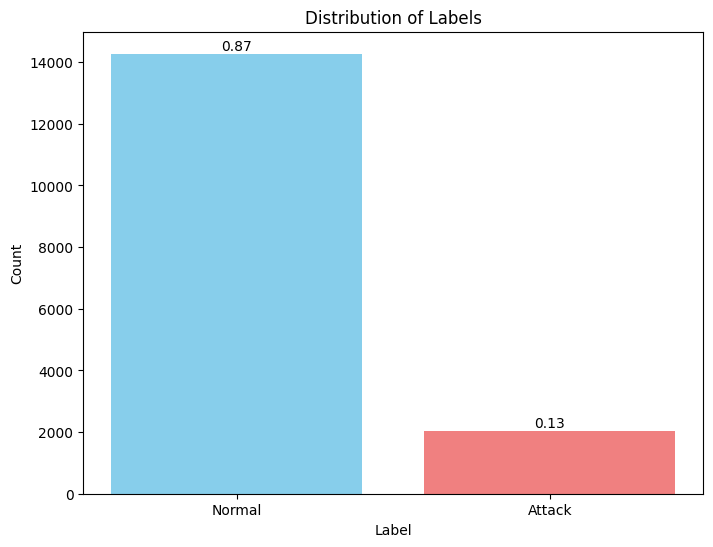

In [ ]:

import matplotlib.pyplot as plt

label_counts = df_2020['Label'].value_counts()
label_fractions = label_counts / len(df_2020)

plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts, color=['skyblue', 'lightcoral'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Add fraction labels to the bars
for bar, fraction in zip(bars, label_fractions):
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, f'{fraction:.2f}', ha='center', va='bottom')

# Replace 0 and 1 with 'Normal' and 'Attack' in the x-axis labels
plt.xticks([0, 1], ['Normal', 'Attack'])

plt.show()


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_2020.drop('Label', axis=1)  # Features (44 columns)
y = df_2020['Label']  # Labels (0 for Normal, 1 for Attack)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features before applying LDA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=1)  # Since it's binary classification
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Train an Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.13, random_state=42)  # contamination=percentage of anomalies
iso_forest.fit(X_train_lda)

# Get predictions (-1 = anomaly, 1 = normal in Isolation Forest terms)
iso_forest_predictions = iso_forest.predict(X_test_lda)

# Convert Isolation Forest's output to match your labels (1 = Attack, 0 = Normal)
iso_forest_predictions = [1 if x == -1 else 0 for x in iso_forest_predictions]

# Evaluate the performance using various metrics
conf_matrix = confusion_matrix(y_test, iso_forest_predictions)
precision = precision_score(y_test, iso_forest_predictions)
recall = recall_score(y_test, iso_forest_predictions)
f1 = f1_score(y_test, iso_forest_predictions)
accuracy = accuracy_score(y_test, iso_forest_predictions)

# Binary Multiclass Accuracy (BMA)
bma = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) +
       conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])) / 2

# Print the results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Binary Multiclass Accuracy (BMA): {bma}")


Confusion Matrix:
[[4282    0]
 [   0  614]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
Binary Multiclass Accuracy (BMA): 1.0


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_2020.drop('Label', axis=1)  # Features (44 columns)
y = df_2020['Label']  # Labels (0 for Normal, 1 for Attack)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features before applying Isolation Forest
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.13, random_state=42)  # contamination=percentage of anomalies
iso_forest.fit(X_train_scaled)

# Get predictions (-1 = anomaly, 1 = normal in Isolation Forest terms)
iso_forest_predictions = iso_forest.predict(X_test_scaled)

# Convert Isolation Forest's output to match your labels (1 = Attack, 0 = Normal)
iso_forest_predictions = [1 if x == -1 else 0 for x in iso_forest_predictions]

# Evaluate the performance using various metrics
conf_matrix = confusion_matrix(y_test, iso_forest_predictions)
precision = precision_score(y_test, iso_forest_predictions)
recall = recall_score(y_test, iso_forest_predictions)
f1 = f1_score(y_test, iso_forest_predictions)
accuracy = accuracy_score(y_test, iso_forest_predictions)

# Binary Multiclass Accuracy (BMA)
bma = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) +
       conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])) / 2

# Print the results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Binary Multiclass Accuracy (BMA): {bma}")


Confusion Matrix:
[[3956  326]
 [ 290  324]]
Precision: 0.49846153846153846
Recall: 0.5276872964169381
F1 Score: 0.5126582278481012
Accuracy: 0.8741830065359477
Binary Multiclass Accuracy (BMA): 0.7257773240608745


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the dataset
# Assuming df_2020 is your dataframe
X = df_2020.drop('Label', axis=1)  # Features (44 columns)
y = df_2020['Label']  # Labels (0 for Normal, 1 for Attack)

# Convert cudf DataFrames/Series to pandas if necessary
import cudf
if isinstance(X, cudf.DataFrame):
    X = X.to_pandas()
if isinstance(y, cudf.Series):
    y = y.to_pandas()

# Convert features and labels to NumPy arrays
X_np = X.values
y_np = y.values

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.3, random_state=42, stratify=y_np)

# Step 3: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the TabNet model without Isolation Forest
clf = TabNetClassifier()
clf.fit(X_train_scaled, y_train, max_epochs=100, patience=10)

# Step 5: Predict using the TabNet model
y_pred = clf.predict(X_test_scaled)

# Step 6: Evaluate the TabNet model using various metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Binary Multiclass Accuracy (BMA)
bma = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) +
       conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])) / 2

# Step 7: Print the results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Binary Multiclass Accuracy (BMA): {bma}")


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.44082 |  0:00:01s
epoch 1  | loss: 0.18623 |  0:00:01s
epoch 2  | loss: 0.03622 |  0:00:02s
epoch 3  | loss: 0.00707 |  0:00:03s
epoch 4  | loss: 0.00773 |  0:00:03s
epoch 5  | loss: 0.00288 |  0:00:04s
epoch 6  | loss: 0.00249 |  0:00:04s
epoch 7  | loss: 0.00518 |  0:00:05s
epoch 8  | loss: 0.00365 |  0:00:05s
epoch 9  | loss: 0.00483 |  0:00:06s
epoch 10 | loss: 0.00303 |  0:00:06s
epoch 11 | loss: 0.00112 |  0:00:07s
epoch 12 | loss: 0.00178 |  0:00:07s
epoch 13 | loss: 0.00351 |  0:00:08s
epoch 14 | loss: 0.00167 |  0:00:08s
epoch 15 | loss: 0.002   |  0:00:09s
epoch 16 | loss: 0.00059 |  0:00:09s
epoch 17 | loss: 0.00061 |  0:00:10s
epoch 18 | loss: 0.00198 |  0:00:10s
epoch 19 | loss: 0.00185 |  0:00:11s
epoch 20 | loss: 0.00067 |  0:00:11s
epoch 21 | loss: 0.00052 |  0:00:12s
epoch 22 | loss: 0.00057 |  0:00:12s
epoch 23 | loss: 0.00044 |  0:00:13s
epoch 24 | loss: 0.00044 |  0:00:13s
epoch 25 | loss: 0.00354 |  0:00:14s
epoch 26 | loss: 0.00056 |  0:00:14s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.62231 |  0:00:00s
epoch 1  | loss: 0.20765 |  0:00:01s
epoch 2  | loss: 0.05586 |  0:00:01s
epoch 3  | loss: 0.02612 |  0:00:02s
epoch 4  | loss: 0.01506 |  0:00:02s
epoch 5  | loss: 0.00945 |  0:00:03s
epoch 6  | loss: 0.00867 |  0:00:04s
epoch 7  | loss: 0.00326 |  0:00:04s
epoch 8  | loss: 0.00154 |  0:00:05s
epoch 9  | loss: 0.00231 |  0:00:05s
epoch 10 | loss: 0.0011  |  0:00:06s
epoch 11 | loss: 0.00086 |  0:00:07s
epoch 12 | loss: 0.00082 |  0:00:07s
epoch 13 | loss: 0.00167 |  0:00:08s
epoch 14 | loss: 0.00113 |  0:00:08s
epoch 15 | loss: 0.00076 |  0:00:09s
epoch 16 | loss: 0.0007  |  0:00:10s
epoch 17 | loss: 0.00067 |  0:00:10s
epoch 18 | loss: 0.0009  |  0:00:11s
epoch 19 | loss: 0.00065 |  0:00:11s
epoch 20 | loss: 0.00066 |  0:00:12s
epoch 21 | loss: 0.00062 |  0:00:12s
epoch 22 | loss: 0.00165 |  0:00:13s
epoch 23 | loss: 0.00211 |  0:00:14s
epoch 24 | loss: 0.00073 |  0:00:14s
epoch 25 | loss: 0.00066 |  0:00:15s
epoch 26 | loss: 0.00069 |  0:00:15s
e

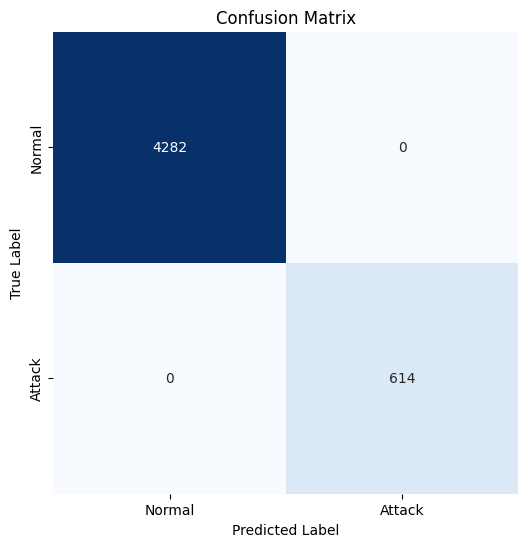

  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: only integer scalar arrays can be converted to a scalar index

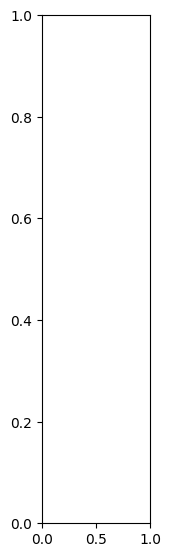

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import cudf

# Step 1: Prepare the dataset
X = df_2020.drop('Label', axis=1)  # Features (44 columns)
y = df_2020['Label']  # Labels (0 for Normal, 1 for Attack)

# Convert cudf DataFrame to pandas (if applicable)
if isinstance(X, cudf.DataFrame):
    X = X.to_pandas()
if isinstance(y, cudf.Series):
    y = y.to_pandas()

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train an Isolation Forest to get anomaly scores
iso_forest = IsolationForest(contamination=0.13, random_state=42)
iso_forest.fit(X_train_scaled)

# Step 5: Get anomaly scores (higher = more anomalous)
train_anomaly_scores = iso_forest.decision_function(X_train_scaled)
test_anomaly_scores = iso_forest.decision_function(X_test_scaled)

# Step 6: Add anomaly scores as a new feature
X_train_with_anomaly = np.column_stack((X_train_scaled, train_anomaly_scores))
X_test_with_anomaly = np.column_stack((X_test_scaled, test_anomaly_scores))

# Step 7: Train the TabNet model (forcing to CPU if necessary)
clf = TabNetClassifier(device_name='cpu')  # Switch to CPU to avoid CUDA issues

# Ensure y_train is a NumPy array before fitting
y_train = np.array(y_train)

clf.fit(X_train_with_anomaly, y_train, max_epochs=30, patience=10)

# Step 8: Save TabNet model weights for transfer learning
clf.save_model("tabnet_wustl_ehms_2020_weights")

# Step 9: Predict using the TabNet model
y_pred = clf.predict(X_test_with_anomaly)

# Step 10: Evaluate the TabNet model using various metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Binary Multiclass Accuracy (BMA)
bma = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) +
       conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])) / 2

# Step 11: Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

import shap

# Step 12: SHAP explainability using KernelExplainer
# Sample a subset of the training data for SHAP due to KernelExplainer's high computational cost
X_train_sample = X_train_with_anomaly[:100]  # Take 100 samples from the training set

# Initialize SHAP KernelExplainer for TabNet
explainer = shap.KernelExplainer(clf.predict_proba, X_train_sample)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_with_anomaly[:100])  # Use a small test set sample for efficiency

# Ensure the number of feature names matches the number of columns in X_test_with_anomaly
feature_names = list(X.columns) + ['Anomaly_Score']

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_with_anomaly[:100], feature_names=feature_names)



  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: only integer scalar arrays can be converted to a scalar index

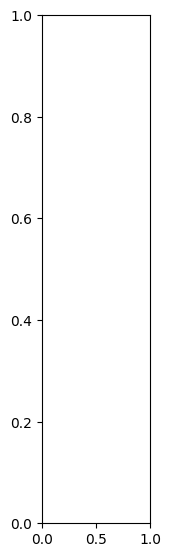

In [ ]:
# Step 12: SHAP explainability using KernelExplainer
# Sample a subset of the training data for SHAP due to KernelExplainer's high computational cost
X_train_sample = X_train_with_anomaly[:100]  # Take 100 samples from the training set

# Initialize SHAP KernelExplainer for TabNet
explainer = shap.KernelExplainer(clf.predict_proba, X_train_sample)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_with_anomaly[:100])  # Use a small test set sample for efficiency

# Ensure the number of feature names matches the number of columns in X_test_with_anomaly
feature_names = list(X.columns) + ['Anomaly_Score']

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_with_anomaly[:100], feature_names=feature_names)


## Working on 2021 dataset

In [ ]:
df_2021.head()

,StartTime,LastTime,SrcAddr,DstAddr,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,...,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Label
0,2019-08-19 12:23:28,2019-08-19 12:23:28,192.168.0.20,192.168.0.2,0,59034,502,10,8,18,...,24,20,44,0.001176,0.053037,0,0.000000,0.0,normal,0
1,2019-08-19 15:13:24,2019-08-19 15:13:24,192.168.0.20,192.168.0.2,0,55841,502,10,8,18,...,24,20,44,0.001308,0.052681,0,0.000000,0.0,normal,0
2,2019-08-19 13:41:31,2019-08-19 13:41:31,192.168.0.20,192.168.0.2,0,63774,502,10,8,18,...,24,20,44,0.000690,0.051793,0,0.000000,0.0,normal,0
3,2019-08-19 12:43:19,2019-08-19 12:43:20,209.240.235.92,192.168.0.2,0,61771,80,4,0,4,...,0,0,0,0.000000,0.889555,0,419.338813,0.0,DoS,1
4,2019-08-19 14:49:44,2019-08-19 14:49:48,192.168.0.20,192.168.0.1,3,0,0,14,0,14,...,476,0,476,0.000000,3.500055,0,525.146562,0.0,normal,0


In [ ]:
df_2021.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1194464 entries, 0 to 1194463
Data columns (total 49 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   StartTime   1194464 non-null  object
 1   LastTime    1194464 non-null  object
 2   SrcAddr     1194464 non-null  object
 3   DstAddr     1194464 non-null  object
 4   Mean        1194464 non-null  int64
 5   Sport       1194464 non-null  int64
 6   Dport       1194464 non-null  int64
 7   SrcPkts     1194464 non-null  int64
 8   DstPkts     1194464 non-null  int64
 9   TotPkts     1194464 non-null  int64
 10  DstBytes    1194464 non-null  int64
 11  SrcBytes    1194464 non-null  int64
 12  TotBytes    1194464 non-null  int64
 13  SrcLoad     1194464 non-null  float64
 14  DstLoad     1194464 non-null  float64
 15  Load        1194464 non-null  float64
 16  SrcRate     1194464 non-null  float64
 17  DstRate     1194464 non-null  float64
 18  Rate        1194464 non-null  float64
 19  Src

In [ ]:
df_2021['Traffic'].value_counts()

,count
Traffic,
normal,1107448
DoS,78305
Reconn,8240
CommInj,259
Backdoor,212


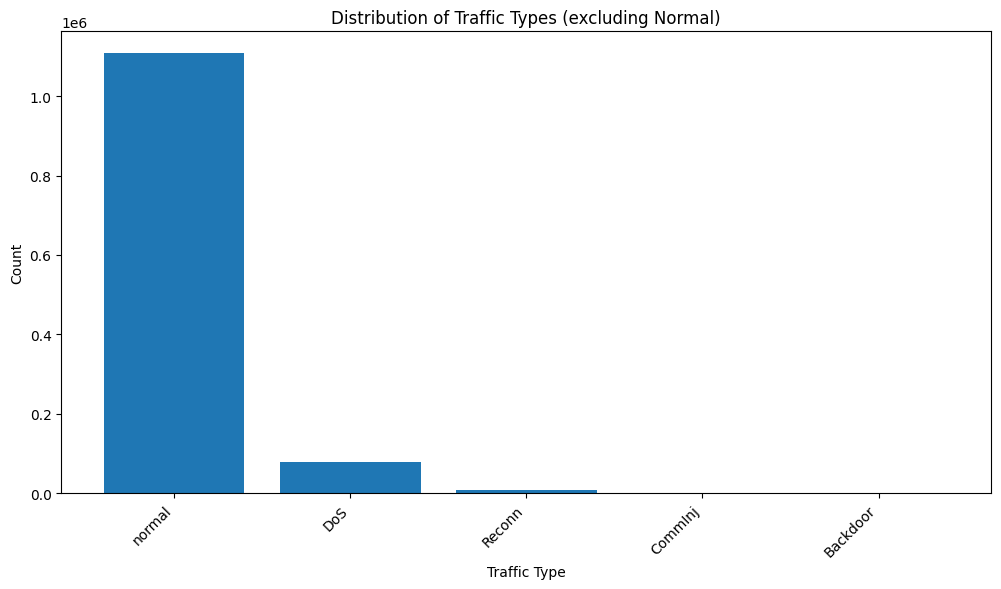

In [ ]:

traffic_counts = df_2021['Traffic'].value_counts()


plt.figure(figsize=(12, 6))
plt.bar(traffic_counts.index, traffic_counts.values)
plt.xlabel('Traffic Type')
plt.ylabel('Count')
plt.title('Distribution of Traffic Types (excluding Normal)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


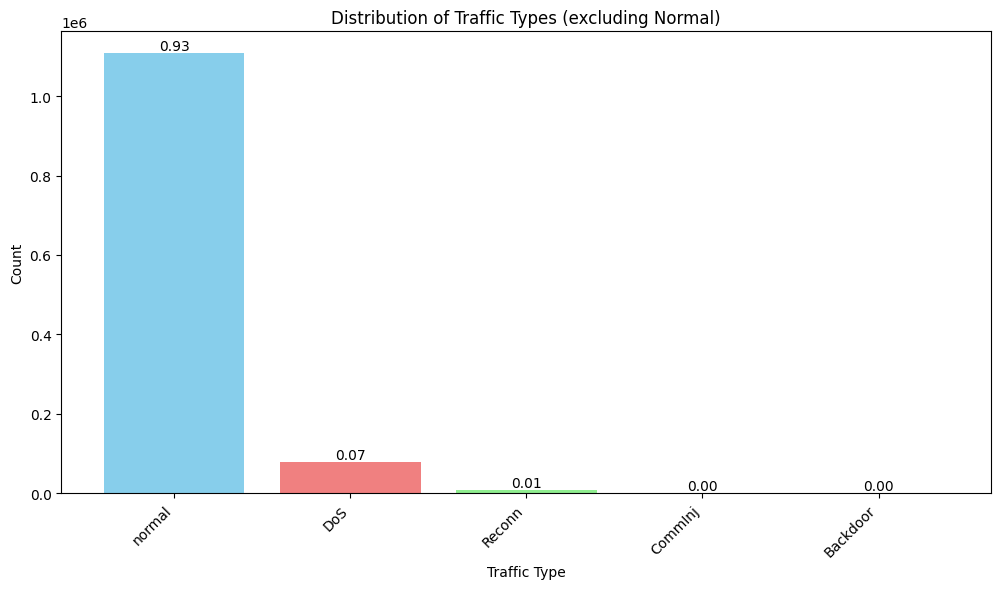

In [ ]:

import matplotlib.pyplot as plt

traffic_counts = df_2021['Traffic'].value_counts()
traffic_fractions = traffic_counts / len(df_2021)

plt.figure(figsize=(12, 6))
bars = plt.bar(traffic_counts.index, traffic_counts.values, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple'])
plt.xlabel('Traffic Type')
plt.ylabel('Count')
plt.title('Distribution of Traffic Types (excluding Normal)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability


# Add fraction labels to the bars
for bar, fraction in zip(bars, traffic_fractions):
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, f'{fraction:.2f}', ha='center', va='bottom')

plt.show()


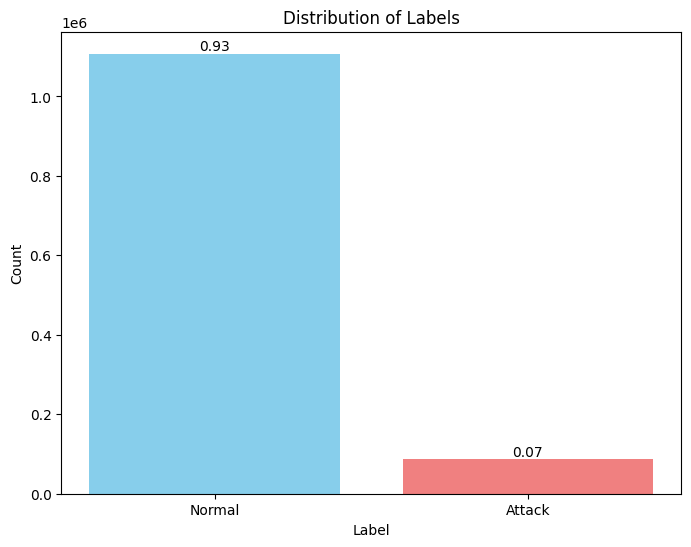

In [ ]:

label_counts = df_2021['Label'].value_counts()
label_fractions = label_counts / len(df_2021)

plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts, color=['skyblue', 'lightcoral'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Add fraction labels to the bars
for bar, fraction in zip(bars, label_fractions):
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, f'{fraction:.2f}', ha='center', va='bottom')

# Replace 0 and 1 with 'Normal' and 'Attack' in the x-axis labels
plt.xticks([0, 1], ['Normal', 'Attack'])

plt.show()


In [ ]:

import pandas as pd


datetime_columns = [col for col in df_2021.columns if 'time' in col.lower() or 'date' in col.lower()]

if datetime_columns:
  print("Datetime columns found:")
  for col in datetime_columns:
    print(col)

  # Convert the datetime columns to datetime objects
  for col in datetime_columns:
    try:
      df_2021[col] = pd.to_datetime(df_2021[col])
    except Exception as e:
      print(f"Error converting {col} to datetime: {e}")

  # Extract features from datetime columns
  for col in datetime_columns:
    if pd.api.types.is_datetime64_any_dtype(df_2021[col]):
      df_2021[col + '_year'] = df_2021[col].dt.year
      df_2021[col + '_month'] = df_2021[col].dt.month
      df_2021[col + '_day'] = df_2021[col].dt.day
      df_2021[col + '_hour'] = df_2021[col].dt.hour
      df_2021[col + '_minute'] = df_2021[col].dt.minute
      df_2021[col + '_second'] = df_2021[col].dt.second
      df_2021[col + '_dayofweek'] = df_2021[col].dt.dayofweek
      # You can add more features like dayofyear, weekofyear, quarter, etc. as needed

  print("\nDataFrame with extracted datetime features:")
  print(df_2021.head())
else:
  print("No datetime columns found in the DataFrame.")


Datetime columns found:
StartTime
LastTime
IdleTime
RunTime

DataFrame with extracted datetime features:
            StartTime            LastTime         SrcAddr      DstAddr  Mean  \
0 2019-08-19 12:23:28 2019-08-19 12:23:28    192.168.0.20  192.168.0.2     0   
1 2019-08-19 15:13:24 2019-08-19 15:13:24    192.168.0.20  192.168.0.2     0   
2 2019-08-19 13:41:31 2019-08-19 13:41:31    192.168.0.20  192.168.0.2     0   
3 2019-08-19 12:43:19 2019-08-19 12:43:20  209.240.235.92  192.168.0.2     0   
4 2019-08-19 14:49:44 2019-08-19 14:49:48    192.168.0.20  192.168.0.1     3   

   Sport  Dport  SrcPkts  DstPkts  TotPkts  ...  IdleTime_minute  \
0  59034    502       10        8       18  ...                0   
1  55841    502       10        8       18  ...                0   
2  63774    502       10        8       18  ...                0   
3  61771     80        4        0        4  ...                0   
4      0      0       14        0       14  ...                0   

   Id

In [ ]:
df_2021 = df_2021.drop(['StartTime' , 'LastTime' ], axis = 1)

In [ ]:

for column in df_2021.select_dtypes(include=['object']):
  le = LabelEncoder()
  df_2021[column] = le.fit_transform(df_2021[column])


In [ ]:
df_2021.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1194464 entries, 0 to 1194463
Data columns (total 75 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   SrcAddr              1194464 non-null  int64
 1   DstAddr              1194464 non-null  int64
 2   Mean                 1194464 non-null  int64
 3   Sport                1194464 non-null  int64
 4   Dport                1194464 non-null  int64
 5   SrcPkts              1194464 non-null  int64
 6   DstPkts              1194464 non-null  int64
 7   TotPkts              1194464 non-null  int64
 8   DstBytes             1194464 non-null  int64
 9   SrcBytes             1194464 non-null  int64
 10  TotBytes             1194464 non-null  int64
 11  SrcLoad              1194464 non-null  float64
 12  DstLoad              1194464 non-null  float64
 13  Load                 1194464 non-null  float64
 14  SrcRate              1194464 non-null  float64
 15  DstRate              1

In [ ]:
for column in ['IdleTime', 'RunTime']:
  try:
    df_2021[column] = pd.to_numeric(df_2021[column], errors='coerce')
  except Exception as e:
    print(f"Error converting {column} to numeric: {e}")

df_2021['IdleTime'].fillna(0, inplace=True)
df_2021['RunTime'].fillna(0, inplace=True)


In [ ]:
df_2021.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1194464 entries, 0 to 1194463
Data columns (total 75 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   SrcAddr              1194464 non-null  int64
 1   DstAddr              1194464 non-null  int64
 2   Mean                 1194464 non-null  int64
 3   Sport                1194464 non-null  int64
 4   Dport                1194464 non-null  int64
 5   SrcPkts              1194464 non-null  int64
 6   DstPkts              1194464 non-null  int64
 7   TotPkts              1194464 non-null  int64
 8   DstBytes             1194464 non-null  int64
 9   SrcBytes             1194464 non-null  int64
 10  TotBytes             1194464 non-null  int64
 11  SrcLoad              1194464 non-null  float64
 12  DstLoad              1194464 non-null  float64
 13  Load                 1194464 non-null  float64
 14  SrcRate              1194464 non-null  float64
 15  DstRate              1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02215 |  0:00:43s
epoch 1  | loss: 0.00903 |  0:01:28s
epoch 2  | loss: 0.0019  |  0:02:12s
epoch 3  | loss: 0.00162 |  0:02:56s
epoch 4  | loss: 0.00116 |  0:03:41s
epoch 5  | loss: 0.00124 |  0:04:25s
epoch 6  | loss: 0.00144 |  0:05:10s
epoch 7  | loss: 0.00112 |  0:05:54s
epoch 8  | loss: 0.00119 |  0:06:38s
epoch 9  | loss: 0.00076 |  0:07:23s


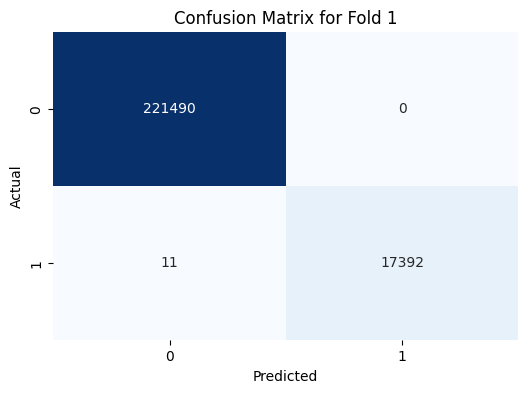

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02376 |  0:00:44s
epoch 1  | loss: 0.00251 |  0:01:27s
epoch 2  | loss: 0.00193 |  0:02:11s
epoch 3  | loss: 0.00101 |  0:02:55s
epoch 4  | loss: 0.00918 |  0:03:39s
epoch 5  | loss: 0.00578 |  0:04:22s
epoch 6  | loss: 0.0018  |  0:05:05s
epoch 7  | loss: 0.00128 |  0:05:48s
epoch 8  | loss: 0.00258 |  0:06:31s
epoch 9  | loss: 0.00516 |  0:07:14s


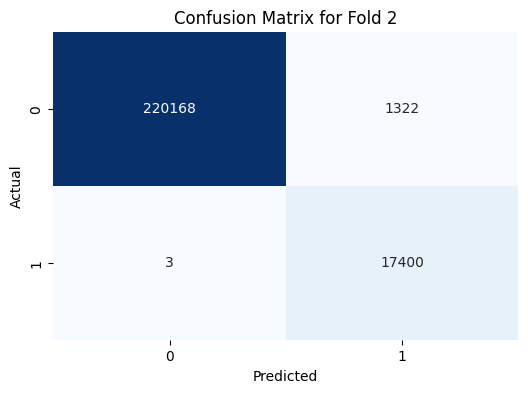

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02416 |  0:00:43s
epoch 1  | loss: 0.00332 |  0:01:25s
epoch 2  | loss: 0.00177 |  0:02:08s
epoch 3  | loss: 0.00142 |  0:02:51s
epoch 4  | loss: 0.00082 |  0:03:34s
epoch 5  | loss: 0.0012  |  0:04:17s
epoch 6  | loss: 0.00058 |  0:05:00s
epoch 7  | loss: 0.00258 |  0:05:43s
epoch 8  | loss: 0.00081 |  0:06:26s
epoch 9  | loss: 0.00078 |  0:07:09s


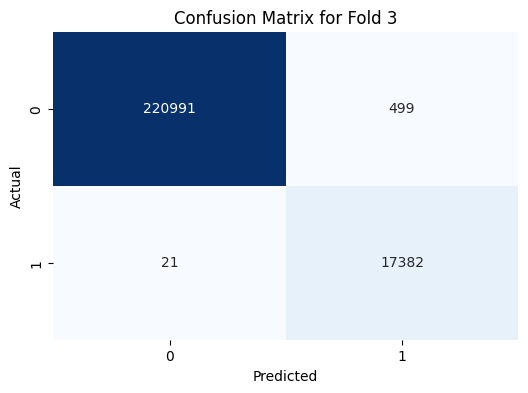

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02193 |  0:00:42s
epoch 1  | loss: 0.00323 |  0:01:25s
epoch 2  | loss: 0.00129 |  0:02:08s
epoch 3  | loss: 0.00812 |  0:02:51s
epoch 4  | loss: 0.00206 |  0:03:34s
epoch 5  | loss: 0.00159 |  0:04:17s
epoch 6  | loss: 0.00197 |  0:05:00s
epoch 7  | loss: 0.00173 |  0:05:43s
epoch 8  | loss: 0.00233 |  0:06:26s
epoch 9  | loss: 0.00361 |  0:07:09s


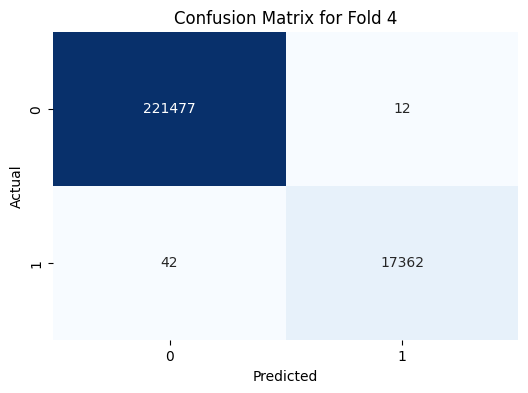

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.01997 |  0:00:42s
epoch 1  | loss: 0.00361 |  0:01:24s
epoch 2  | loss: 0.00649 |  0:02:07s
epoch 3  | loss: 0.00231 |  0:02:49s
epoch 4  | loss: 0.00234 |  0:03:32s
epoch 5  | loss: 0.00174 |  0:04:14s
epoch 6  | loss: 0.00144 |  0:04:58s
epoch 7  | loss: 0.00122 |  0:05:40s
epoch 8  | loss: 0.00304 |  0:06:22s
epoch 9  | loss: 0.00188 |  0:07:05s


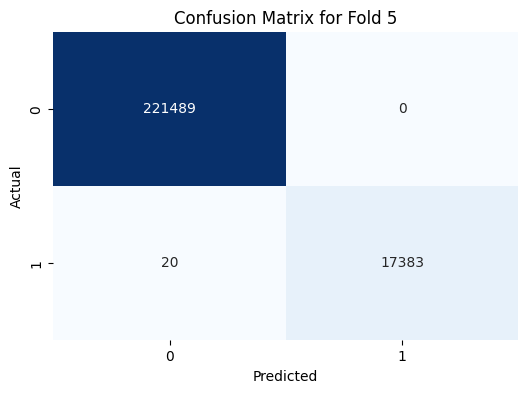

   Fold  Precision    Recall  F1 Score  Accuracy
0     1   1.000000  0.999368  0.999684  0.999954
1     2   0.929388  0.999828  0.963322  0.994454
2     3   0.972093  0.998793  0.985262  0.997823
3     4   0.999309  0.997587  0.998447  0.999774
4     5   1.000000  0.998851  0.999425  0.999916


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Initialize a Stratified K-Fold cross-validator
n_splits = 5  # Define the number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# DataFrame to hold evaluation metrics
metrics_df = pd.DataFrame(columns=['Fold', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

# Loop through each fold
for fold, (train_index, test_index) in enumerate(skf.split(X_new, y_new), 1):
    # Split the data into train and test sets for this fold
    X_train_fold, X_test_fold = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train_fold, y_test_fold = y_new.iloc[train_index], y_new.iloc[test_index]

    # Convert y_train_fold and y_test_fold to numpy arrays
    y_train_fold = y_train_fold.values
    y_test_fold = y_test_fold.values

    # Standardize the new dataset
    X_train_scaled_fold = scaler.fit_transform(X_train_fold)
    X_test_scaled_fold = scaler.transform(X_test_fold)

    # Fine-tune the TabNet model on this fold's training data
    clf_new.fit(X_train_scaled_fold, y_train_fold, max_epochs=10, patience=10)

    # Predict on this fold's test data
    y_pred_fold = clf_new.predict(X_test_scaled_fold)

    # Ensure y_pred_fold is a numpy array
    y_pred_fold = np.array(y_pred_fold)

    # Compute the confusion matrix for this fold
    conf_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)

    # Plot the confusion matrix for this fold
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix_fold, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate evaluation metrics for this fold
    precision_fold = precision_score(y_test_fold, y_pred_fold)
    recall_fold = recall_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)

    # Save metrics in the DataFrame using concat
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Fold': [fold],
        'Precision': [precision_fold],
        'Recall': [recall_fold],
        'F1 Score': [f1_fold],
        'Accuracy': [accuracy_fold]
    })], ignore_index=True)

# Print the evaluation metrics for each fold
print(metrics_df)

Successfully saved model at tabnet_wustl_ehms_2021_weights.zip
Confusion Matrix:
[[4282    0]
 [   0  614]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
Binary Multiclass Accuracy (BMA): 1.0


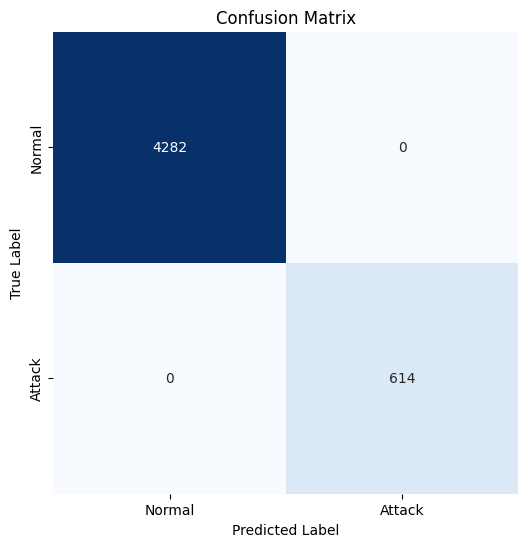

In [ ]:

# Step 8: Save TabNet model weights for transfer learning
clf.save_model("tabnet_wustl_ehms_2021_weights")

# Step 9: Predict using the TabNet model on the test set
y_pred = clf.predict(X_test_with_anomaly)

# Step 10: Evaluate the TabNet model using various metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Binary Multiclass Accuracy (BMA)
bma = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) +
       conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])) / 2

# Step 11: Print the results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Binary Multiclass Accuracy (BMA): {bma}")

# Step 12: Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
metrics_df

,Fold,Precision,Recall,F1 Score,Accuracy
0,1,1.000000,0.999368,0.999684,0.999954
1,2,0.929388,0.999828,0.963322,0.994454
2,3,0.972093,0.998793,0.985262,0.997823
3,4,0.999309,0.997587,0.998447,0.999774
4,5,1.000000,0.998851,0.999425,0.999916


In [ ]:
X = df_2021.drop('Traffic' , axis = 1)
y = df_2021['Traffic']

In [ ]:
# prompt: normalize X and y and name them as X_new and y_new

from sklearn.preprocessing import MinMaxScaler

# Assuming X and y are your feature matrix and target variable
scaler = MinMaxScaler()
X_new = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y_new = y


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02703 |  0:00:41s
epoch 1  | loss: 0.00138 |  0:01:23s
epoch 2  | loss: 0.00096 |  0:02:04s
epoch 3  | loss: 0.00122 |  0:02:45s
epoch 4  | loss: 0.00121 |  0:03:27s
epoch 5  | loss: 0.00084 |  0:04:08s
epoch 6  | loss: 0.00141 |  0:04:50s
epoch 7  | loss: 0.00057 |  0:05:31s
epoch 8  | loss: 0.00062 |  0:06:14s
epoch 9  | loss: 0.00042 |  0:06:56s


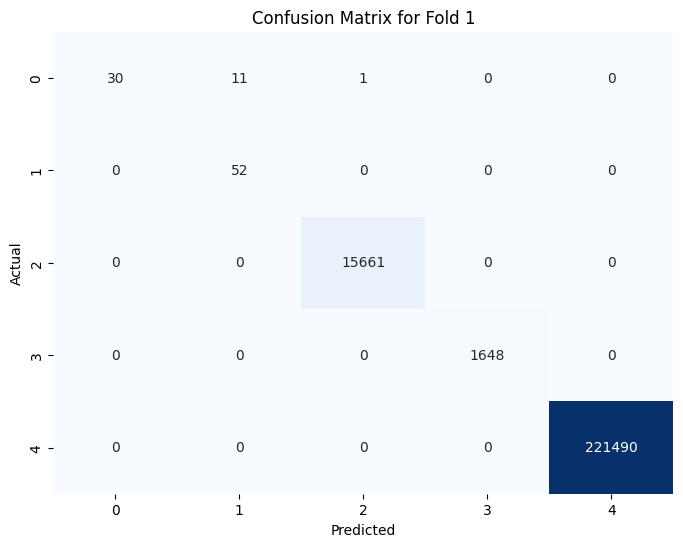


Fold 1 Metrics:
Precision: 1.0000
Recall: 0.9999
F1 Score: 0.9999
Accuracy: 0.9999


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0314  |  0:00:41s
epoch 1  | loss: 0.00341 |  0:01:23s
epoch 2  | loss: 0.00118 |  0:02:04s
epoch 3  | loss: 0.00081 |  0:02:46s
epoch 4  | loss: 0.00085 |  0:03:27s
epoch 5  | loss: 0.00128 |  0:04:09s
epoch 6  | loss: 0.00063 |  0:04:50s
epoch 7  | loss: 0.0005  |  0:05:32s
epoch 8  | loss: 0.00046 |  0:06:14s
epoch 9  | loss: 0.00063 |  0:06:56s


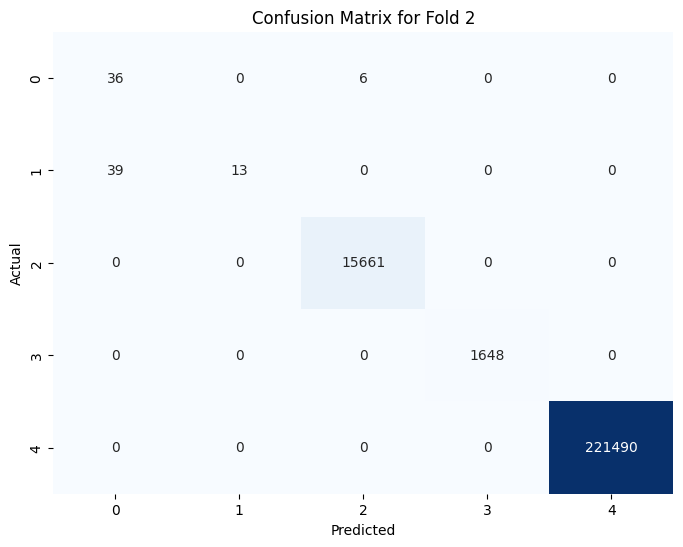


Fold 2 Metrics:
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998
Accuracy: 0.9998


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02852 |  0:00:41s
epoch 1  | loss: 0.00383 |  0:01:23s
epoch 2  | loss: 0.00189 |  0:02:05s
epoch 3  | loss: 0.00238 |  0:02:47s
epoch 4  | loss: 0.0014  |  0:03:29s
epoch 5  | loss: 0.00132 |  0:04:10s
epoch 6  | loss: 0.00103 |  0:04:52s
epoch 7  | loss: 0.00103 |  0:05:35s
epoch 8  | loss: 0.00075 |  0:06:16s
epoch 9  | loss: 0.00049 |  0:06:58s


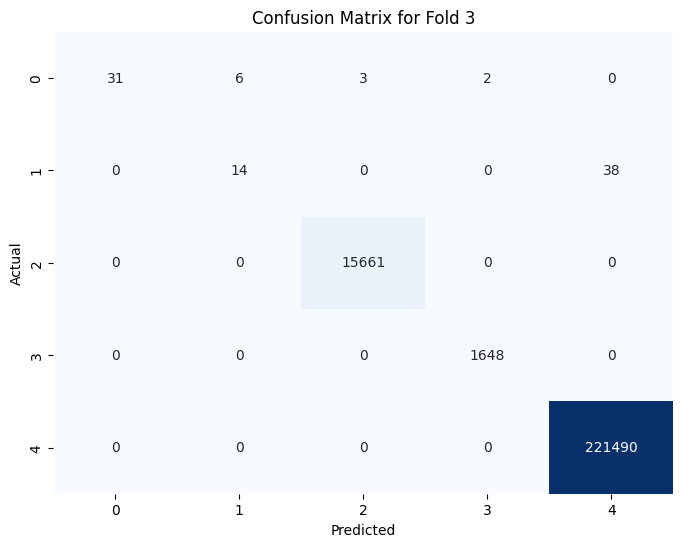


Fold 3 Metrics:
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9998
Accuracy: 0.9998


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02991 |  0:00:41s
epoch 1  | loss: 0.00224 |  0:01:23s
epoch 2  | loss: 0.00198 |  0:02:04s
epoch 3  | loss: 0.00124 |  0:02:46s
epoch 4  | loss: 0.00179 |  0:03:28s
epoch 5  | loss: 0.0011  |  0:04:09s
epoch 6  | loss: 0.00091 |  0:04:51s
epoch 7  | loss: 0.00078 |  0:05:32s
epoch 8  | loss: 0.00083 |  0:06:14s
epoch 9  | loss: 0.0008  |  0:06:56s


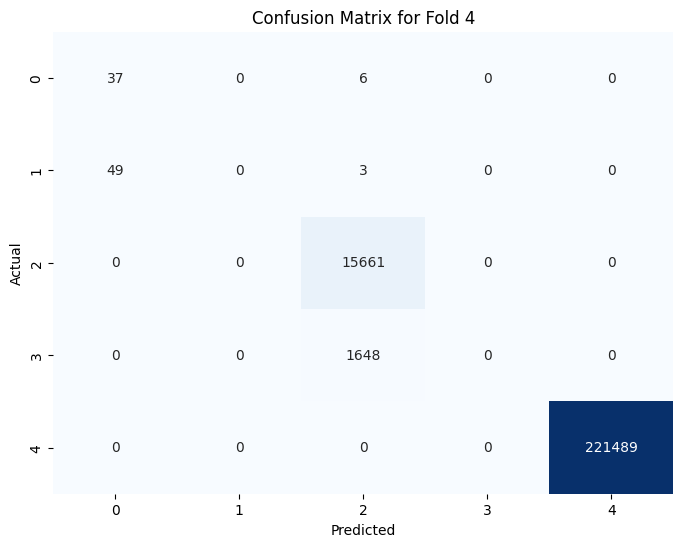

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Fold 4 Metrics:
Precision: 0.9865
Recall: 0.9929
F1 Score: 0.9895
Accuracy: 0.9929


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.02636 |  0:00:41s
epoch 1  | loss: 0.00116 |  0:01:23s
epoch 2  | loss: 0.00076 |  0:02:05s
epoch 3  | loss: 0.00068 |  0:02:46s
epoch 4  | loss: 0.001   |  0:03:28s
epoch 5  | loss: 0.00064 |  0:04:09s
epoch 6  | loss: 0.00174 |  0:04:51s
epoch 7  | loss: 0.00077 |  0:05:32s
epoch 8  | loss: 0.0003  |  0:06:14s
epoch 9  | loss: 0.00027 |  0:06:56s


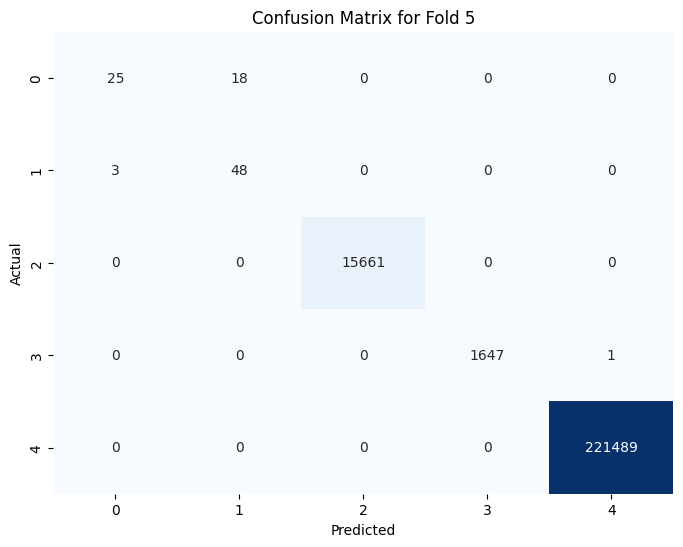


Fold 5 Metrics:
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999
Accuracy: 0.9999

Metrics for each class:
    Fold  Class  Precision    Recall  F1 Score
0      1      0   1.000000  0.714286  0.833333
1      1      1   0.825397  1.000000  0.904348
2      1      2   0.999936  1.000000  0.999968
3      1      3   1.000000  1.000000  1.000000
4      1      4   1.000000  1.000000  1.000000
5      2      0   0.480000  0.857143  0.615385
6      2      1   1.000000  0.250000  0.400000
7      2      2   0.999617  1.000000  0.999808
8      2      3   1.000000  1.000000  1.000000
9      2      4   1.000000  1.000000  1.000000
10     3      0   1.000000  0.738095  0.849315
11     3      1   0.700000  0.269231  0.388889
12     3      2   0.999808  1.000000  0.999904
13     3      3   0.998788  1.000000  0.999394
14     3      4   0.999828  1.000000  0.999914
15     4      0   0.430233  0.860465  0.573643
16     4      1   0.000000  0.000000  0.000000
17     4      2   0.904319  1.000000  0.94975

ValueError: Unknown format code 'd' for object of type 'float'

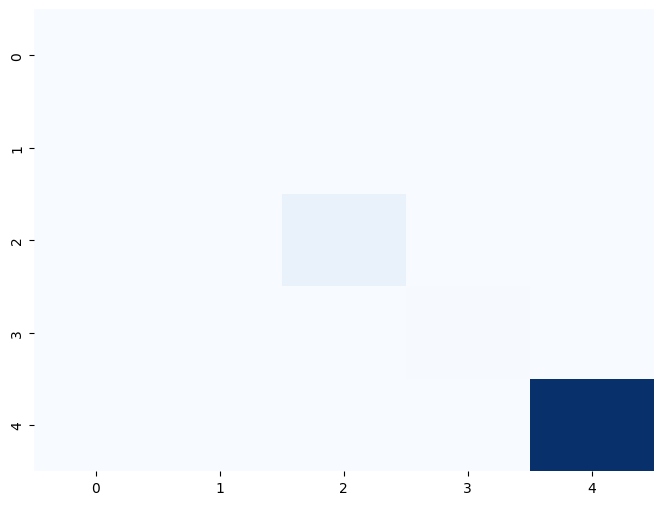

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, accuracy_score)
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier  # Ensure TabNetClassifier is imported

# Initialize a Stratified K-Fold cross-validator
n_splits = 5  # Define the number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# DataFrame to hold evaluation metrics
metrics_df = pd.DataFrame(columns=['Fold', 'Class', 'Precision', 'Recall', 'F1 Score'])
overall_conf_matrix = np.zeros((len(np.unique(y_new)), len(np.unique(y_new))))

# Initialize the scaler and TabNet classifier
scaler = StandardScaler()
clf_new = TabNetClassifier()  # Configure parameters as needed

# Loop through each fold
for fold, (train_index, test_index) in enumerate(skf.split(X_new, y_new), 1):
    # Split the data into train and test sets for this fold
    X_train_fold, X_test_fold = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train_fold, y_test_fold = y_new.iloc[train_index], y_new.iloc[test_index]

    # Convert y_train_fold and y_test_fold to numpy arrays
    y_train_fold = y_train_fold.values
    y_test_fold = y_test_fold.values

    # Standardize the new dataset
    X_train_scaled_fold = scaler.fit_transform(X_train_fold)
    X_test_scaled_fold = scaler.transform(X_test_fold)

    # Fine-tune the TabNet model on this fold's training data
    clf_new.fit(X_train_scaled_fold, y_train_fold, max_epochs=10, patience=10)

    # Predict on this fold's test data
    y_pred_fold = clf_new.predict(X_test_scaled_fold)

    # Ensure y_pred_fold is a numpy array
    y_pred_fold = np.array(y_pred_fold)

    # Compute the confusion matrix for this fold
    conf_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold, labels=np.unique(y_new))
    overall_conf_matrix += conf_matrix_fold

    # Plot the confusion matrix for this fold
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_fold, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_new), yticklabels=np.unique(y_new))
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate evaluation metrics for each class
    report = classification_report(y_test_fold, y_pred_fold, labels=np.unique(y_new), output_dict=True)

    for class_label in np.unique(y_new):
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Fold': [fold],
            'Class': [class_label],
            'Precision': [report[str(class_label)]['precision']],
            'Recall': [report[str(class_label)]['recall']],
            'F1 Score': [report[str(class_label)]['f1-score']]
        })], ignore_index=True)

    # Calculate and print overall metrics for this fold
    precision_fold = precision_score(y_test_fold, y_pred_fold, average='weighted')
    recall_fold = recall_score(y_test_fold, y_pred_fold, average='weighted')
    f1_fold = f1_score(y_test_fold, y_pred_fold, average='weighted')
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)

    print(f'\nFold {fold} Metrics:')
    print(f'Precision: {precision_fold:.4f}')
    print(f'Recall: {recall_fold:.4f}')
    print(f'F1 Score: {f1_fold:.4f}')
    print(f'Accuracy: {accuracy_fold:.4f}')

# Print the evaluation metrics for each fold
print('\nMetrics for each class:')
print(metrics_df)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_new), yticklabels=np.unique(y_new))
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Applying on 2024 dataset

In [ ]:
df_2024

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,sswap_sin,sswap_sout,sdiskusage_total,sdiskusage_used,sdiskusage_free,sdiskusage_percent,Boot_Time_with_date,DTime,Attack_categories,Label
0,->,e,192.168.3.2,192.168.2.2,36390,4022,1651.0,272.0,10440.0,1612.000,...,0,0,502392610816,51814645760,424982593536,10,2023-12-23 15:38:11,104.316401,normal,0
1,->,e,192.168.3.2,192.168.2.2,49608,4022,1673.0,272.0,10576.0,1611.000,...,0,0,502392610816,51814674432,424982564864,10,2023-12-23 15:38:11,104.207156,normal,0
2,->,e,192.168.3.2,192.168.2.2,34596,4022,1650.0,272.0,10364.0,1602.000,...,0,0,502392610816,51814686720,424982552576,10,2023-12-23 15:38:11,104.177347,normal,0
3,->,e d,78.151.208.250,192.168.2.2,18346,4022,1450.0,174.0,0.0,306.469,...,0,0,502392610858,50459127848,426338111537,15,2023-05-09 15:19:38,25.821966,DDoS,1
4,->,e d,143.109.155.233,192.168.2.2,18346,4022,1452.0,174.0,0.0,305.268,...,0,0,502392610863,50459127854,426338111539,15,2023-05-09 15:19:38,25.945508,DDoS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145118,->,e d,210.199.96.247,192.168.4.2,3617,4022,1453.0,174.0,0.0,307.200,...,0,0,502392611534,50459128438,426338112161,80,2023-05-09 15:19:38,10.176143,DDoS,1
145119,->,e d,52.213.241.61,192.168.4.2,3617,4022,1452.0,174.0,0.0,306.281,...,0,0,502392611536,50459128445,426338112166,80,2023-05-09 15:19:38,10.152515,DDoS,1
145120,->,e d,250.243.186.7,192.168.4.2,3617,4022,1450.0,174.0,0.0,306.492,...,0,0,502392611545,50459128446,426338112174,81,2023-05-09 15:19:38,10.068303,DDoS,1
145121,->,e,198.51.100.100,192.168.4.2,57484,4022,1648.0,272.0,10397.0,1608.000,...,0,0,30612852736,19991822336,9289617408,68,2023-12-23 15:40:42,28.217784,normal,0


In [ ]:
df_2024.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 145123 entries, 0 to 145122
Data columns (total 77 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   Dir                        145123 non-null  object
 1   Flgs                       145123 non-null  object
 2   SrcAddr                    145123 non-null  object
 3   DstAddr                    145123 non-null  object
 4   Sport                      145123 non-null  object
 5   Dport                      145123 non-null  int64
 6   SrcBytes                   145123 non-null  float64
 7   DstBytes                   145123 non-null  float64
 8   SrcLoad                    145123 non-null  float64
 9   DstLoad                    145123 non-null  float64
 10  SrcGap                     145123 non-null  float64
 11  DstGap                     145123 non-null  float64
 12  SIntPkt                    145123 non-null  float64
 13  DIntPkt                    145123 non-

In [ ]:
df_2024 = df_2024.drop('Dir' , axis =1 )

In [ ]:
# prompt: label encode all other object columns and print the label mapping for the column 'Attack_categories'

from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder
le = LabelEncoder()

# Iterate through object columns (excluding 'Attack_Categories')
for column in df_2024.select_dtypes(include=['object']):
  if column != 'Attack_categories':
    df_2024[column] = le.fit_transform(df_2024[column])

# Label encode 'Attack_Categories' and print the mapping
le_attack = LabelEncoder()
df_2024['Attack_categories'] = le_attack.fit_transform(df_2024['Attack_categories'])
print("Label Mapping for 'Attack_categories':")
for i, label in enumerate(le_attack.classes_):
  print(f"{label}: {i}")


Label Mapping for 'Attack_categories':
Buffer_overflow: 0
DDoS: 1
MiTM: 2
Ransomware: 3
normal: 4


In [ ]:
X = df_2024.drop(['Attack_categories', 'Label'] , axis = 1)
y = df_2024['Attack_categories']

In [ ]:
# prompt: apply RFE on X and y , normalize the data before hand if necessary

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Initialize the model for RFE (Logistic Regression in this case)
model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

# Create the RFE object
rfe = RFE(estimator=model, n_features_to_select=10)  # Select top 10 features

# Fit RFE to the data
X_rfe = rfe.fit_transform(X_normalized, y)

# Get the selected features
selected_features = X.columns[rfe.support_]

# Print the selected features
print("Selected features:")
print(selected_features)



Selected features:
Index(['sMaxPktSz', 'sMinPktSz', 'SrcMac', 'IMEI', 'Packet_num',
       'scputimes_idle', 'scpustats_ctx_switches', 'scpustats_interrupts',
       'svmem_used', 'DTime'],
      dtype='object')


In [ ]:

# import the LinearDiscriminantAnalysis class
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create a new dataset with selected features
X_lda = df_2024[selected_features]

# Initialize LDA
lda = LinearDiscriminantAnalysis()

# Fit LDA on the new dataset
X_lda_transformed = lda.fit_transform(X_lda, y)

# Print the shape of the transformed data
print("Shape of LDA-transformed data:", X_lda_transformed.shape)

Shape of LDA-transformed data: (145123, 3)


Metrics:
Precision: 0.8417
Recall: 0.9981
F1 Score: 0.9133
Accuracy: 0.9840


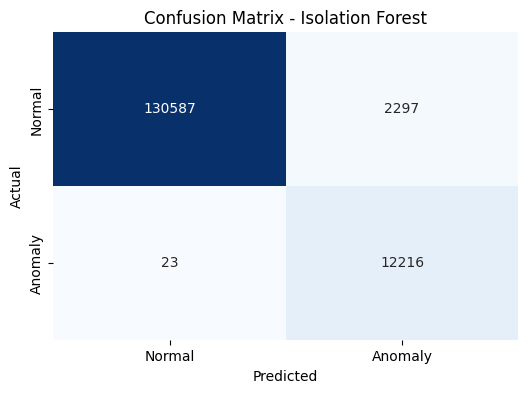

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the label for y
y = df_2024['Label']

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the Isolation Forest on the LDA-transformed data
iso_forest.fit(X_lda_transformed)

# Predict anomaly scores (-1 for outliers and 1 for inliers)
y_pred = iso_forest.predict(X_lda_transformed)

# Map the predictions to binary classes (anomaly vs normal)
# Assuming that 'Label' has 1 for normal data and -1 for anomalies
y_pred_binary = np.where(y_pred == 1, 0, 1)  # 0: normal, 1: anomaly

# Add anomaly scores to the dataset
df_2024['Anomaly_Score'] = iso_forest.decision_function(X_lda_transformed)
df_2024['Anomaly_Prediction'] = y_pred_binary

# Evaluate the performance using various metrics
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)
accuracy = accuracy_score(y, y_pred_binary)

print("Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title("Confusion Matrix - Isolation Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the updated dataset with anomaly scores
df_2024.to_csv('dataset_with_anomaly_scores.csv', index=False)


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

epoch 0  | loss: 0.04919 |  0:00:05s
epoch 1  | loss: 0.00795 |  0:00:09s
epoch 2  | loss: 0.00717 |  0:00:13s
epoch 3  | loss: 0.01068 |  0:00:16s
epoch 4  | loss: 0.00763 |  0:00:20s
epoch 5  | loss: 0.00648 |  0:00:24s
epoch 6  | loss: 0.00646 |  0:00:28s
epoch 7  | loss: 0.00542 |  0:00:31s
epoch 8  | loss: 0.00647 |  0:00:35s
epoch 9  | loss: 0.00584 |  0:00:39s


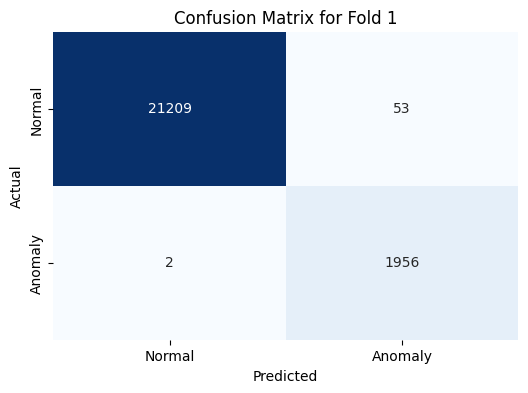

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.04368 |  0:00:03s
epoch 1  | loss: 0.00701 |  0:00:07s
epoch 2  | loss: 0.00709 |  0:00:11s
epoch 3  | loss: 0.00635 |  0:00:14s
epoch 4  | loss: 0.00573 |  0:00:18s
epoch 5  | loss: 0.0059  |  0:00:22s
epoch 6  | loss: 0.00615 |  0:00:26s
epoch 7  | loss: 0.00713 |  0:00:30s
epoch 8  | loss: 0.00564 |  0:00:33s
epoch 9  | loss: 0.00515 |  0:00:37s


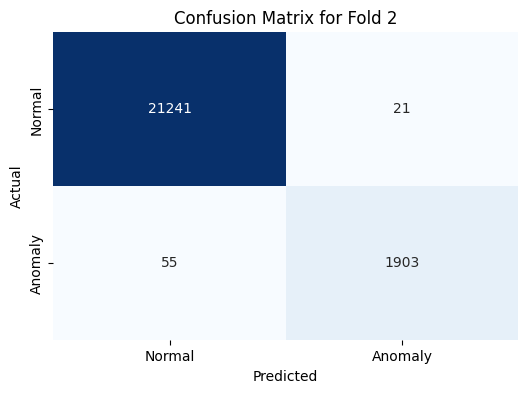

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.05112 |  0:00:03s
epoch 1  | loss: 0.00729 |  0:00:07s
epoch 2  | loss: 0.00662 |  0:00:11s
epoch 3  | loss: 0.00611 |  0:00:15s
epoch 4  | loss: 0.00647 |  0:00:18s
epoch 5  | loss: 0.00638 |  0:00:22s
epoch 6  | loss: 0.00575 |  0:00:26s
epoch 7  | loss: 0.00562 |  0:00:30s
epoch 8  | loss: 0.00627 |  0:00:33s
epoch 9  | loss: 0.00598 |  0:00:37s


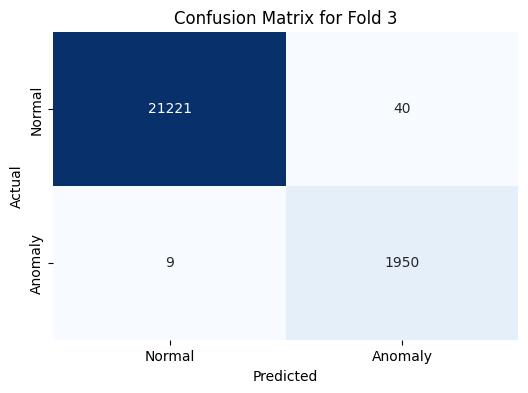

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.04203 |  0:00:03s
epoch 1  | loss: 0.00729 |  0:00:07s
epoch 2  | loss: 0.00743 |  0:00:11s
epoch 3  | loss: 0.00652 |  0:00:15s
epoch 4  | loss: 0.0061  |  0:00:18s
epoch 5  | loss: 0.00586 |  0:00:22s
epoch 6  | loss: 0.00569 |  0:00:26s
epoch 7  | loss: 0.00648 |  0:00:30s
epoch 8  | loss: 0.00617 |  0:00:34s
epoch 9  | loss: 0.00574 |  0:00:38s


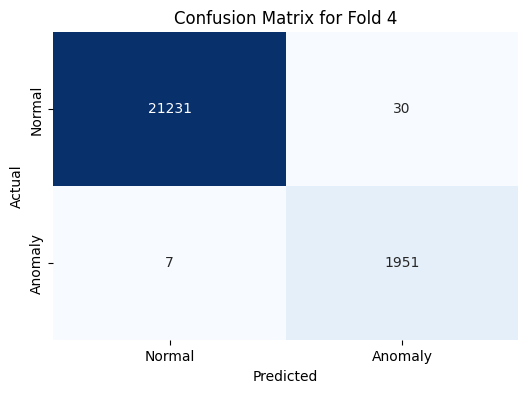

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.07133 |  0:00:03s
epoch 1  | loss: 0.00838 |  0:00:07s
epoch 2  | loss: 0.00705 |  0:00:11s
epoch 3  | loss: 0.00652 |  0:00:15s
epoch 4  | loss: 0.00642 |  0:00:19s
epoch 5  | loss: 0.00768 |  0:00:22s
epoch 6  | loss: 0.00795 |  0:00:26s
epoch 7  | loss: 0.00728 |  0:00:30s
epoch 8  | loss: 0.00693 |  0:00:34s
epoch 9  | loss: 0.00637 |  0:00:38s


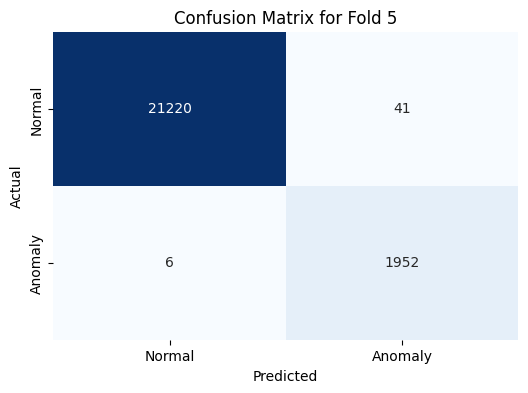

Metrics for each fold:
   Fold  Precision    Recall  F1 Score  Accuracy       BMA
0     1   0.973619  0.998979  0.986136  0.997631  0.998243
1     2   0.989085  0.971910  0.980422  0.996727  0.985461
2     3   0.979899  0.995406  0.987592  0.997890  0.996762
3     4   0.984856  0.996425  0.990607  0.998406  0.997507
4     5   0.979428  0.996936  0.988104  0.997976  0.997504


ValueError: Unknown format code 'd' for object of type 'float'

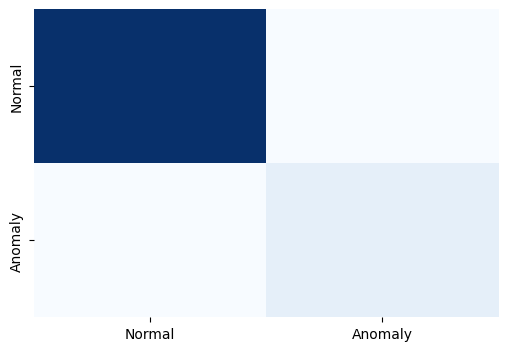

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set label and features
X = X_lda_transformed  # LDA-transformed dataset
y = df_2024['Label'].values  # The target labels

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize a Stratified K-Fold cross-validator for 5-folds on the training set
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# DataFrame to hold evaluation metrics
metrics_df = pd.DataFrame(columns=['Fold', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'BMA'])
overall_conf_matrix = np.zeros((2, 2))  # For binary classification (normal vs anomaly)

# Initialize TabNet classifier
clf_tabnet = TabNetClassifier()

# Load the pre-trained model weights from df_2021 (use the correct path for weights)
pretrained_weights_path = '/content/drive/MyDrive/IOMT/tabnet_wustl_ehms_2021_weights.zip'
clf_tabnet.load_model(pretrained_weights_path)

# Loop through each fold for cross-validation on the training set
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    # Split the training data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fine-tune the TabNet model on the training data of this fold
    clf_tabnet.fit(X_train_fold, y_train_fold, max_epochs=10, patience=5, batch_size=1024, virtual_batch_size=128)

    # Predict on validation data of this fold
    y_pred_val = clf_tabnet.predict(X_val_fold)

    # Calculate confusion matrix for this fold
    conf_matrix_fold = confusion_matrix(y_val_fold, y_pred_val)

    # Plot confusion matrix for this fold
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix_fold, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate evaluation metrics for this fold
    precision_fold = precision_score(y_val_fold, y_pred_val)
    recall_fold = recall_score(y_val_fold, y_pred_val)
    f1_fold = f1_score(y_val_fold, y_pred_val)
    accuracy_fold = accuracy_score(y_val_fold, y_pred_val)

    # Balanced Mean Accuracy (BMA)
    tn, fp, fn, tp = conf_matrix_fold.ravel()
    bma_fold = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp)))

    # Save metrics in the DataFrame using concat
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Fold': [fold],
        'Precision': [precision_fold],
        'Recall': [recall_fold],
        'F1 Score': [f1_fold],
        'Accuracy': [accuracy_fold],
        'BMA': [bma_fold]
    })], ignore_index=True)

    # Update the overall confusion matrix
    overall_conf_matrix += conf_matrix_fold

# Print the evaluation metrics for each fold
print("Metrics for each fold:")
print(metrics_df)

# Plot the overall confusion matrix for the cross-validation process
plt.figure(figsize=(6, 4))
sns.heatmap(overall_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Overall Confusion Matrix for 5-Fold Cross-Validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



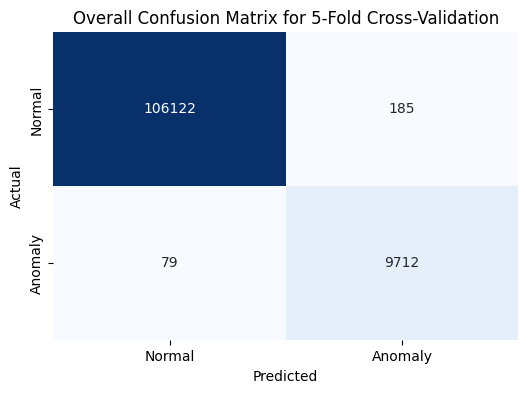

In [ ]:
# Cast the confusion matrix to integers before plotting
overall_conf_matrix_int = overall_conf_matrix.astype(int)

# Plot the overall confusion matrix for the cross-validation process
plt.figure(figsize=(6, 4))
sns.heatmap(overall_conf_matrix_int, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Overall Confusion Matrix for 5-Fold Cross-Validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


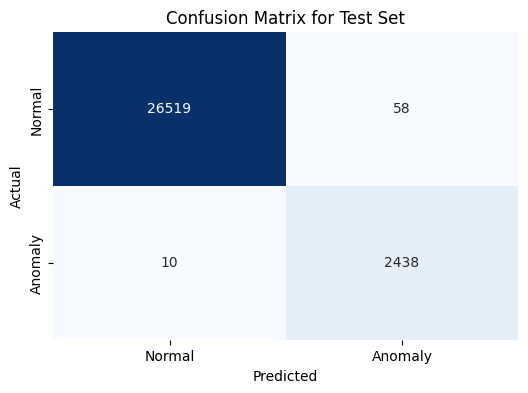


Test Set Metrics:
Precision: 0.9768
Recall: 0.9959
F1 Score: 0.9862
Accuracy: 0.9977
BMA: 0.9969


In [ ]:
# After training on the 5 folds, test on the test set
y_pred_test = clf_tabnet.predict(X_test)

# Calculate confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate evaluation metrics for the test set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Balanced Mean Accuracy (BMA) for the test set
tn, fp, fn, tp = conf_matrix_test.ravel()
bma_test = 0.5 * ((tp / (tp + fn)) + (tn / (tn + fp)))

print("\nTest Set Metrics:")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"BMA: {bma_test:.4f}")


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

epoch 0  | loss: 0.07356 |  0:00:03s
epoch 1  | loss: 0.00977 |  0:00:07s
epoch 2  | loss: 0.00846 |  0:00:11s
epoch 3  | loss: 0.00813 |  0:00:15s
epoch 4  | loss: 0.00762 |  0:00:18s
epoch 5  | loss: 0.00764 |  0:00:22s
epoch 6  | loss: 0.0072  |  0:00:26s
epoch 7  | loss: 0.00666 |  0:00:30s
epoch 8  | loss: 0.00638 |  0:00:34s
epoch 9  | loss: 0.00656 |  0:00:37s


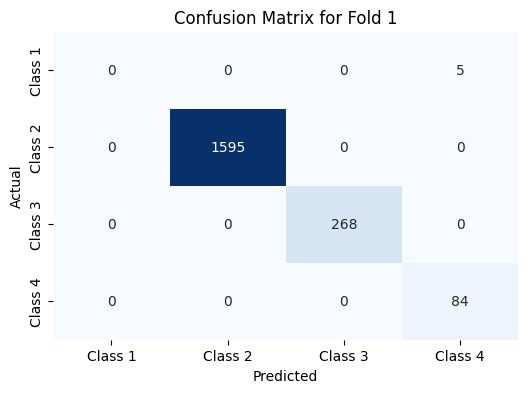

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.10807 |  0:00:03s
epoch 1  | loss: 0.01181 |  0:00:07s
epoch 2  | loss: 0.00975 |  0:00:11s
epoch 3  | loss: 0.00951 |  0:00:15s
epoch 4  | loss: 0.0078  |  0:00:18s
epoch 5  | loss: 0.00846 |  0:00:22s
epoch 6  | loss: 0.00806 |  0:00:26s
epoch 7  | loss: 0.00836 |  0:00:30s
epoch 8  | loss: 0.0132  |  0:00:33s
epoch 9  | loss: 0.00865 |  0:00:37s


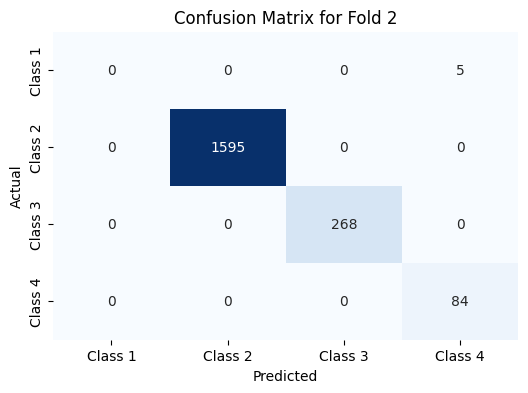

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.09548 |  0:00:03s
epoch 1  | loss: 0.00903 |  0:00:07s
epoch 2  | loss: 0.00752 |  0:00:11s
epoch 3  | loss: 0.0073  |  0:00:15s
epoch 4  | loss: 0.00683 |  0:00:18s
epoch 5  | loss: 0.0065  |  0:00:22s
epoch 6  | loss: 0.00645 |  0:00:26s
epoch 7  | loss: 0.00634 |  0:00:30s
epoch 8  | loss: 0.00702 |  0:00:33s
epoch 9  | loss: 0.00622 |  0:00:37s


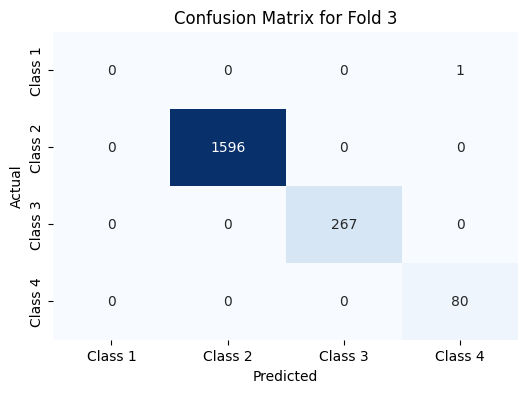

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08894 |  0:00:03s
epoch 1  | loss: 0.01548 |  0:00:07s
epoch 2  | loss: 0.00852 |  0:00:11s
epoch 3  | loss: 0.00872 |  0:00:15s
epoch 4  | loss: 0.00799 |  0:00:18s
epoch 5  | loss: 0.00785 |  0:00:22s
epoch 6  | loss: 0.00742 |  0:00:26s
epoch 7  | loss: 0.00754 |  0:00:30s
epoch 8  | loss: 0.00817 |  0:00:33s
epoch 9  | loss: 0.00731 |  0:00:37s


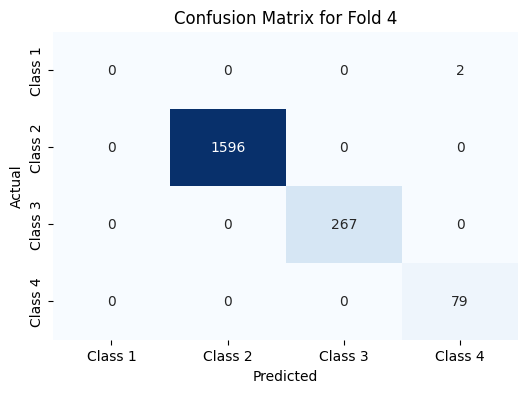

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0904  |  0:00:03s
epoch 1  | loss: 0.00931 |  0:00:07s
epoch 2  | loss: 0.00803 |  0:00:11s
epoch 3  | loss: 0.00712 |  0:00:14s
epoch 4  | loss: 0.00709 |  0:00:18s
epoch 5  | loss: 0.00677 |  0:00:22s
epoch 6  | loss: 0.0069  |  0:00:26s
epoch 7  | loss: 0.00689 |  0:00:29s
epoch 8  | loss: 0.00614 |  0:00:33s
epoch 9  | loss: 0.00689 |  0:00:37s


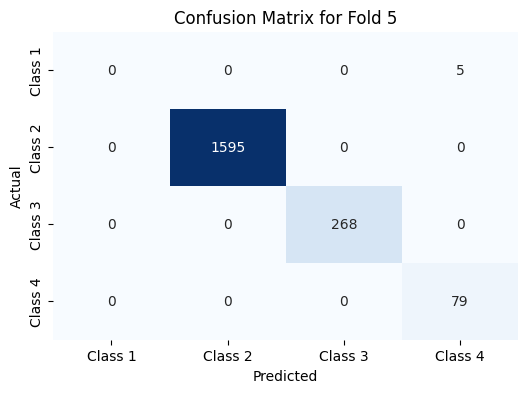

Metrics for each fold:
   Fold  Precision    Recall  F1 Score  Accuracy   BMA
0     1   0.749944  0.799784  0.771292  0.998536  0.75
1     2   0.708330  0.799379  0.740247  0.996684  0.75
2     3   0.735452  0.787887  0.757391  0.997717  0.75
3     4   0.750344  0.785657  0.766137  0.998277  0.75
4     5   0.753295  0.787917  0.768843  0.998493  0.75


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


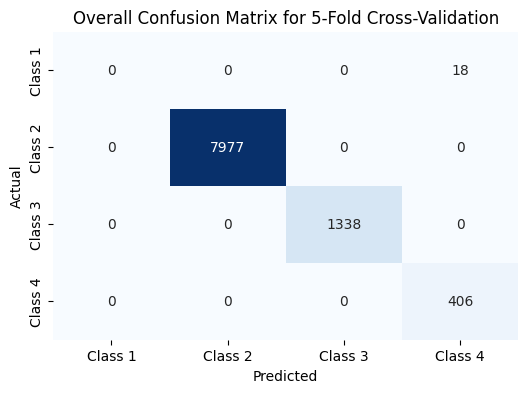

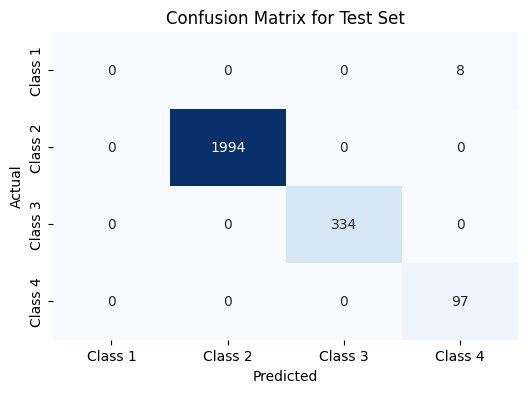

Test Set Precision: 0.7425
Test Set Recall: 0.7828
Test Set F1 Score: 0.7602
Test Set Accuracy: 0.9981


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set label and features
X = X_lda_transformed  # LDA-transformed dataset
y = df_2024['Attack_categories'].values  # The multiclass target labels (4 categories)

# Define the number of classes
n_classes = 4
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize a Stratified K-Fold cross-validator for 5-folds on the training set
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# DataFrame to hold evaluation metrics
metrics_df = pd.DataFrame(columns=['Fold', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'BMA'])
overall_conf_matrix = np.zeros((n_classes, n_classes))  # For multiclass classification with 4 classes

# Initialize TabNet classifier for multiclass classification
clf_tabnet = TabNetClassifier()

# Load the pre-trained model weights from df_2021 (use the correct path for weights)
pretrained_weights_path = '/content/drive/MyDrive/IOMT/tabnet_wustl_ehms_2021_weights.zip'
clf_tabnet.load_model(pretrained_weights_path)

# Loop through each fold for cross-validation on the training set
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    # Split the training data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fine-tune the TabNet model on the training data of this fold
    clf_tabnet.fit(X_train_fold, y_train_fold, max_epochs=10, patience=5, batch_size=1024, virtual_batch_size=128)

    # Predict on validation data of this fold
    y_pred_val = clf_tabnet.predict(X_val_fold)

    # Calculate confusion matrix for this fold (ensure fixed size (4, 4) for all folds)
    conf_matrix_fold = confusion_matrix(y_val_fold, y_pred_val, labels=np.arange(n_classes))

    # Plot confusion matrix for this fold (for multiclass classification)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix_fold, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate evaluation metrics for this fold (use average='macro' for multiclass)
    precision_fold = precision_score(y_val_fold, y_pred_val, average='macro')
    recall_fold = recall_score(y_val_fold, y_pred_val, average='macro')
    f1_fold = f1_score(y_val_fold, y_pred_val, average='macro')
    accuracy_fold = accuracy_score(y_val_fold, y_pred_val)

    # Balanced Mean Accuracy (BMA) calculation (multiclass version)
    bma_fold = np.mean(np.diag(conf_matrix_fold) / np.sum(conf_matrix_fold, axis=1))

    # Save metrics in the DataFrame using concat
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Fold': [fold],
        'Precision': [precision_fold],
        'Recall': [recall_fold],
        'F1 Score': [f1_fold],
        'Accuracy': [accuracy_fold],
        'BMA': [bma_fold]
    })], ignore_index=True)

    # Update the overall confusion matrix
    overall_conf_matrix += conf_matrix_fold

# Print the evaluation metrics for each fold
print("Metrics for each fold:")
print(metrics_df)

# Plot the overall confusion matrix for the cross-validation process (multiclass)
plt.figure(figsize=(6, 4))
sns.heatmap(overall_conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Overall Confusion Matrix for 5-Fold Cross-Validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Test set evaluation
y_pred_test = clf_tabnet.predict(X_test)

# Test set confusion matrix (ensure fixed size (4, 4))
conf_matrix_test = confusion_matrix(y_test, y_pred_test, labels=np.arange(n_classes))

# Plot confusion matrix for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate metrics for the test set
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print test set metrics
print(f"Test Set Precision: {precision_test:.4f}")
print(f"Test Set Recall: {recall_test:.4f}")
print(f"Test Set F1 Score: {f1_test:.4f}")
print(f"Test Set Accuracy: {accuracy_test:.4f}")
